# 拟合优度

拟合优度想要分析的问题是：

有一个关于样本的假设，有一组观察数据，想检验它和理论假设是否相符


## 皮尔逊拟合优度$\chi^2$统计量 | Pearson’s chi-squared test


- 假设 $H_0$
- 若对 $X$ 进行 $n$ 次观测，得到样本 $x_1, \ldots, x_n$，$x = a_i$ 的次数记为 $\nu_i$

检验 $H_0$ 是否成立：
- 理论预言：第 $i$ 个值的个数为 $np_i$
- 实际测量：第 $i$ 个值的个数为 $\nu_i$
- $|np_i - \nu_i|$ 应该尽可能小

定义：

$$
Z = \sum_{i=1}^{k} \frac{(np_i - \nu_i)^2}{np_i}
$$

- $Z$ 符合卡方分布，自由度为 $k-r-1$（$r$ 是理论分布中参数的个数，若分布完全确定，则 $r=0$）


- $Z$ 越大，理论与实验越不符,$Z \geq C$ 认为理论不正确，$C$ 取 $\alpha = 0.05$ 的值
- 最佳值 $Z \approx k-1$，常用 $\frac{Z }{(k-1)}$ 表示与理论的符合度，最佳值 $\approx 1$

注意：在实际应用中，要求样本容量$n>50$,且每一类的理论频数$n p_i\geq5$,否则需要合并类


## p-value
- $p$-value 的概念：当 $Z$ 取特定值 $z$ 时，比它更不可能出现的总概率

p-value其实和比较z值是差不多的意思，p是比较累计概率，而z值是比较x值

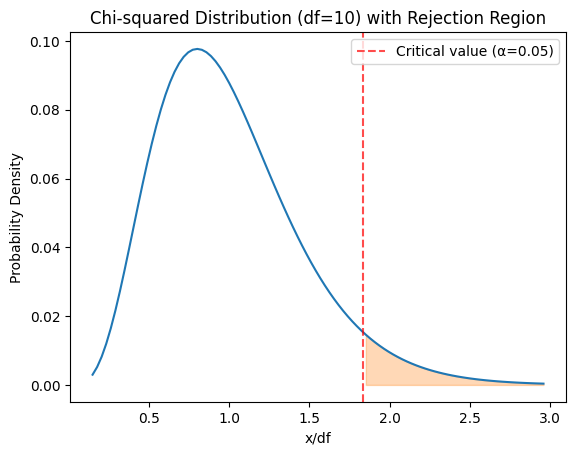

In [1]:
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## chi2函数
ndf=10
rv=st.chi2(ndf)
x=np.linspace(rv.ppf(0.001),rv.ppf(0.999),100)
plt.plot(x/ndf,rv.pdf(x))
plt.fill_between(x/ndf,rv.pdf(x),where=x>rv.ppf(0.95),color='C1',alpha=0.3)
plt.title(f'Chi-squared Distribution (df={ndf}) with Rejection Region')
plt.xlabel('x/df')
plt.ylabel('Probability Density')
plt.axvline(rv.ppf(0.95)/ndf, color='red', linestyle='--', alpha=0.7, label='Critical value (α=0.05)')
plt.legend()

### 案例

![](https://philfan-pic.oss-cn-beijing.aliyuncs.com/img/20241104213835.png)


一家工厂分早、中、晚班。最近发生事故早班6，中班3，晚班6。怀疑事故率与时间有关，如何验证/证伪？

In [2]:
x=(6,3,6)
print(st.chisquare(x)) # 计算卡方统计量 与 p-value

x=(20,10,20)
print(st.chisquare(x))

# 还可以传入理论假设函数
# st.chisquare(x,f_exp=[10**10,10**10,10**10,10**10,10**10,10**10])


Power_divergenceResult(statistic=np.float64(1.2), pvalue=np.float64(0.5488116360940265))
Power_divergenceResult(statistic=np.float64(3.9999999999999996), pvalue=np.float64(0.13533528323661273))


## 对连列表 | Contingency Table


- 变量A分a类，变量B分b类，数据共被分为a×b类
- 总样本n个，每类事例数为$n_{ij}$个
- 理论：对A落入第i个类别的概率为u_i，对B落入第j个类别的概率为v_j
  - $\sum_{i=1}^{a} u_i = 1, \sum_{j=1}^{b} v_j = 1$
- 若AB独立，则落入第ij个类别的概率为
  - $p_{ij} = u_i v_j$
- 检验所有类别的数据与该假设是否符合
  - $Z = \sum_{i=1}^{a} \sum_{j=1}^{b} \frac{(n_{ij} - np_{ij})^2}{np_{ij}}$
- $Z$ 的自由度为 $ab - 1 - (a-1) - (b-1) = (a-1)(b-1)$



### 求 $u_i$ 和 $v_j$ 的最大似然估计
  
  
$$
L = \Pi_{i}\Pi_{j} (u_i v_j)^{n_{ij}}\\
\ln L = \sum_{i,j} n_{ij}(\ln {u_i}+\ln {v_j})\\
u_a = 1-\sum_{i=1}^{a-1} u_i\\
\frac{\partial \ln L}{\partial u_i} = \frac{\sum_j n_{ij}}{u_i} - \frac{\sum_j n_{aj}}{u_a} =0\\

\therefore \frac{\sum_j n_{ij}}{u_i} = \frac{\sum_j n_{1j}+\sum_j n_{2j}+\cdots+\sum_j n_{aj}}{u_1+\cdots+u_{a}} = \frac{n}{1}\\

n_{i\cdot}== \sum_{j=1}^{a} n_{ij}\\

\hat{u}_i = n_{i\cdot}/n\ , \hat{v}_i = v_{i\cdot}/n\\
$$

这里$n_{i\cdot}$表示第i行所有元素的和，$n_{\cdot j}$表示第j列所有元素的和



    ID Treatment     Sex  Age Improved
0   57   Treated    Male   27     Some
1   46   Treated    Male   29      NaN
2   77   Treated    Male   30      NaN
3   17   Treated    Male   32   Marked
4   36   Treated    Male   46   Marked
..  ..       ...     ...  ...      ...
79  32   Placebo  Female   66      NaN
80  42   Placebo  Female   66      NaN
81  15   Placebo  Female   66     Some
82  71   Placebo  Female   68     Some
83   1   Placebo  Female   74   Marked

[84 rows x 5 columns]
Improved   Marked  Some
Treatment              
Placebo         7     7
Treated        21     7


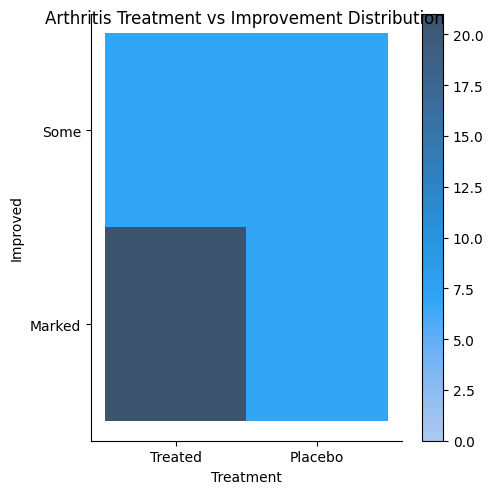

In [3]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = sm.datasets.get_rdataset("Arthritis", "vcd").data
print(df)

# 使用displot绘制可视化

data = df[["Treatment", "Improved"]]
#sns.jointplot(data=data, x="Treatment", y="Improved",)
g = sns.displot(data=data, x="Treatment", y="Improved",cbar=True)
g.fig.suptitle('Arthritis Treatment vs Improvement Distribution')

table = sm.stats.Table.from_data(data)
print(table.table_orig)

In [4]:
data_crosstab = pd.crosstab(data['Treatment'], 
                            data['Improved'],
                                margins = True)
print(data_crosstab)
table2 = sm.stats.Table(data_crosstab)



Improved   Marked  Some  All
Treatment                   
Placebo         7     7   14
Treated        21     7   28
All            28    14   42


In [5]:
print(table.marginal_probabilities)
print(table.fittedvalues)
print(table.test_nominal_association())

(Treatment
Placebo    0.333333
Treated    0.666667
dtype: float64, Improved
Marked    0.666667
Some      0.333333
dtype: float64)
Improved      Marked      Some
Treatment                     
Placebo     9.333333  4.666667
Treated    18.666667  9.333333
df          1
pvalue      0.1051925051200413
statistic   2.625000000000001


In [6]:
st.chi2_contingency(table.table_orig)

Chi2ContingencyResult(statistic=np.float64(1.6205357142857142), pvalue=np.float64(0.20301710604921006), dof=1, expected_freq=array([[ 9.33333333,  4.66666667],
       [18.66666667,  9.33333333]]))